In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import csv
import json
import pickle
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose

2024-11-21 01:41:44.352855: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 01:41:44.428723: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 01:41:44.503192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 01:41:44.503224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 01:41:44.503238: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
# Number of data sheets to be loaded
NUM_DATA_SHEETS = 10
# Number of models in the federated learning setup
NUM_CLIENTS = 30
NUM_CLIENTS_TEST = 6
NUM_CLIENTS = NUM_CLIENTS_TEST
# Number of previous time points used for forecasting the next point
PREVIOUS_LAG = 5
# Number of epochs for training
EPOCHS = 50
# Interval at which to save weights
SAVE_INTERVAL = 1
# Initial learning rate
LEARNING_RATE = 0.01

In [4]:
tf.random.set_seed(3)  # Set random seed for reproducibility

In [5]:
# Function to load all sheets from an Excel file into a dictionary with error handling
def load_data(file_path, sheets):
    data_dict = {}
    for key, sheet in sheets.items():
        try:
            data_dict[key] = pd.read_excel(file_path, sheet_name=sheet)
            print(f"Loaded data for {key} from sheet {sheet}")
        except Exception as e:
            print(f"Failed to load data for {key} from sheet {sheet}: {e}")
    return data_dict

In [6]:
# Define the file path and sheet names with their corresponding keys
# file_path = "Energy consumption data.xlsx"
# sheets = {
#     "building_1_gas": "B1G",
#     "building_1_electricity": "B1E",
#     "building_2_gas": "B2G",
#     "building_2_electricity": "B2E",
#     "building_3_gas": "B3G",
#     "building_3_electricity": "B3E",
# }
file_path = "data/StandardElectricity110Cols1097Rows.xlsx"
sheets = {}
for i in range(NUM_DATA_SHEETS):
    sheets[f'client_{str(i)}'] = f'Sheet_{str(i + 2)}'

In [7]:
# Load the data
dictionary = load_data(file_path, sheets)

Loaded data for client_0 from sheet Sheet_2
Loaded data for client_1 from sheet Sheet_3
Loaded data for client_2 from sheet Sheet_4
Loaded data for client_3 from sheet Sheet_5
Loaded data for client_4 from sheet Sheet_6
Loaded data for client_5 from sheet Sheet_7
Loaded data for client_6 from sheet Sheet_8
Loaded data for client_7 from sheet Sheet_9
Loaded data for client_8 from sheet Sheet_10
Loaded data for client_9 from sheet Sheet_11


In [8]:
# Function to visualize data
def visualize_data(df, title, xlabel, ylabel):
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set(rc={"figure.figsize": (15, 6)})
    sns.histplot(df["Daily Consumption"], bins=50, kde=True, color="blue")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [9]:
# Function to create and compile the model
def create_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dense(16, activation="sigmoid"))
    model.add(Dense(output_shape))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mse", "mae", "mape"]
    )
    return model

In [10]:
# Function to plot data
def plot_the_data(orig_plot, predict_train_plot, predict_test_plot, title):
    plt.figure(figsize=(15, 6))
    plt.plot(orig_plot, color="blue", label="Actual")
    plt.plot(predict_train_plot, color="red", label="Predicted on training")
    plt.plot(predict_test_plot, color="green", label="Predicted on testing")
    plt.legend()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (kWh)")
    plt.show()

In [11]:
# Model inputs
train_size = 0.7  # 70% of the data is used for training
lookback = 7  # 7 days of data is used to predict the next day

In [12]:
# Example for building 1 (Electricity)
# building_name = "building_1_electricity"
# df = dictionary[building_name]
# df["Daily consumption"] = df.iloc[:, 1:-3].sum(axis=1)
building_name = "client_1"
df = dictionary[building_name]
df["Daily Consumption"] = df.iloc[:, 1:-1].sum(axis=1)

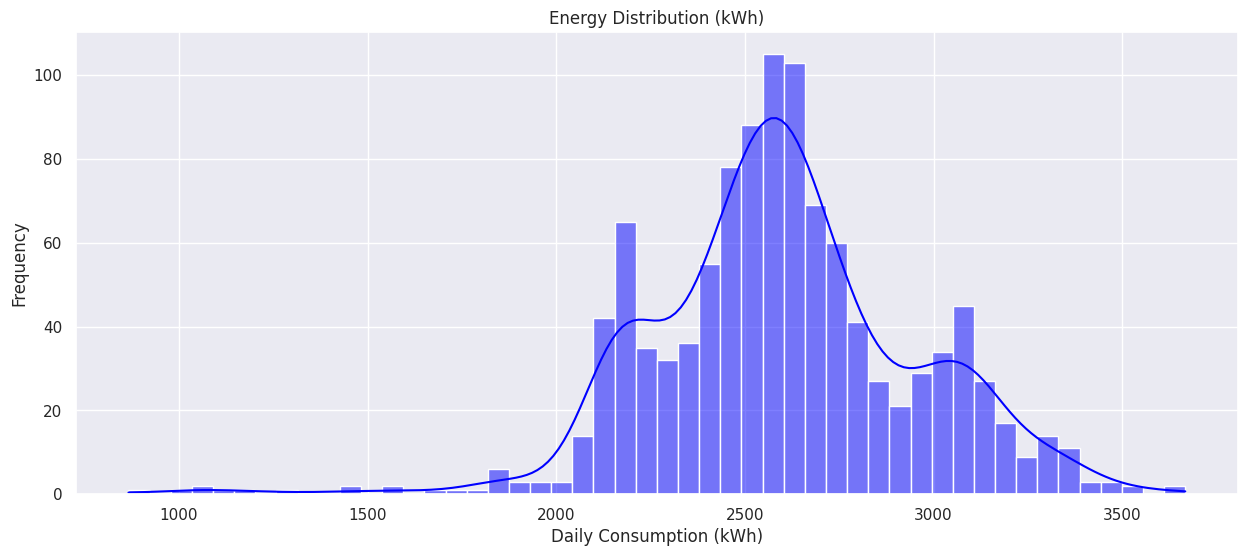

In [13]:
# Visualize data
visualize_data(df, "Energy Distribution (kWh)", "Daily Consumption (kWh)", "Frequency")

In [14]:
# Data preparation functions
def scale_split_datasets(data, train_size, lookback):
    sc_X = StandardScaler()
    daily_consumption_scaled = sc_X.fit_transform(data.values.reshape(-1, 1))
    num_train = int(train_size * len(data))
    training_data = daily_consumption_scaled[:num_train]
    test_data = daily_consumption_scaled[num_train - lookback :]
    return training_data, test_data, sc_X

In [15]:
def create_rnn_dataset(data, lookback):
    data_x, data_y = [], []
    for i in range(len(data) - lookback - 1):
        a = data[i : (i + lookback), 0]
        data_x.append(a)
        data_y.append(data[i + lookback, 0])
    x = np.array(data_x)
    y = np.array(data_y)
    x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
    return x, y

In [16]:
def plot_data_preparation(data, predict_on_train, predict_on_test, lookback):
    total_size = len(predict_on_train) + len(predict_on_test)
    orig_data = data.to_numpy().reshape(len(data), 1)
    orig_plot = np.empty((total_size, 1))
    orig_plot[:, :] = np.nan
    orig_plot[:total_size, :] = orig_data[lookback:-2]
    predict_train_plot = np.empty((total_size, 1))
    predict_train_plot[:, :] = np.nan
    predict_train_plot[: len(predict_on_train), :] = predict_on_train
    predict_test_plot = np.empty((total_size, 1))
    predict_test_plot[:, :] = np.nan
    predict_test_plot[len(predict_on_train) : total_size, :] = predict_on_test
    return orig_plot, predict_train_plot, predict_test_plot

In [17]:
# Scale and split data
training_set, test_data, sc_X = scale_split_datasets(
    df["Daily Consumption"], train_size, lookback
)
x_train, y_train = create_rnn_dataset(training_set, lookback)
x_test, y_test = create_rnn_dataset(test_data, lookback)

In [18]:
# Create and train the model
ts_model = create_model(input_shape=(1, lookback), output_shape=1)
log_dir = "logs/avgfit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

2024-11-21 01:44:20.296695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 01:44:22.268308: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
ts_model.fit(
    x_train,
    y_train,
    epochs=5,
    batch_size=1,
    verbose=1,
    callbacks=[tensorboard_callback],
)

Epoch 1/5
759/759 [==============================] - 3s 2ms/step - loss: 0.4615 - mse: 0.4615 - mae: 0.4258 - mape: 298.8576
Epoch 2/5
759/759 [==============================] - 1s 1ms/step - loss: 0.3146 - mse: 0.3146 - mae: 0.3377 - mape: 306.9069
Epoch 3/5
759/759 [==============================] - 1s 1ms/step - loss: 0.3073 - mse: 0.3073 - mae: 0.3310 - mape: 265.4349
Epoch 4/5
759/759 [==============================] - 1s 2ms/step - loss: 0.3028 - mse: 0.3028 - mae: 0.3276 - mape: 268.5889
Epoch 5/5
759/759 [==============================] - 1s 1ms/step - loss: 0.2972 - mse: 0.2972 - mae: 0.3283 - mape: 267.1950


In [20]:
# Evaluate model
ts_model.evaluate(x_test, y_test, verbose=1)
predict_on_train = ts_model.predict(x_train)
predict_on_test = ts_model.predict(x_test)

11/11 [==============================] - 0s 1ms/step


In [21]:
predict_on_train = sc_X.inverse_transform(predict_on_train)
predict_on_test = sc_X.inverse_transform(predict_on_test)

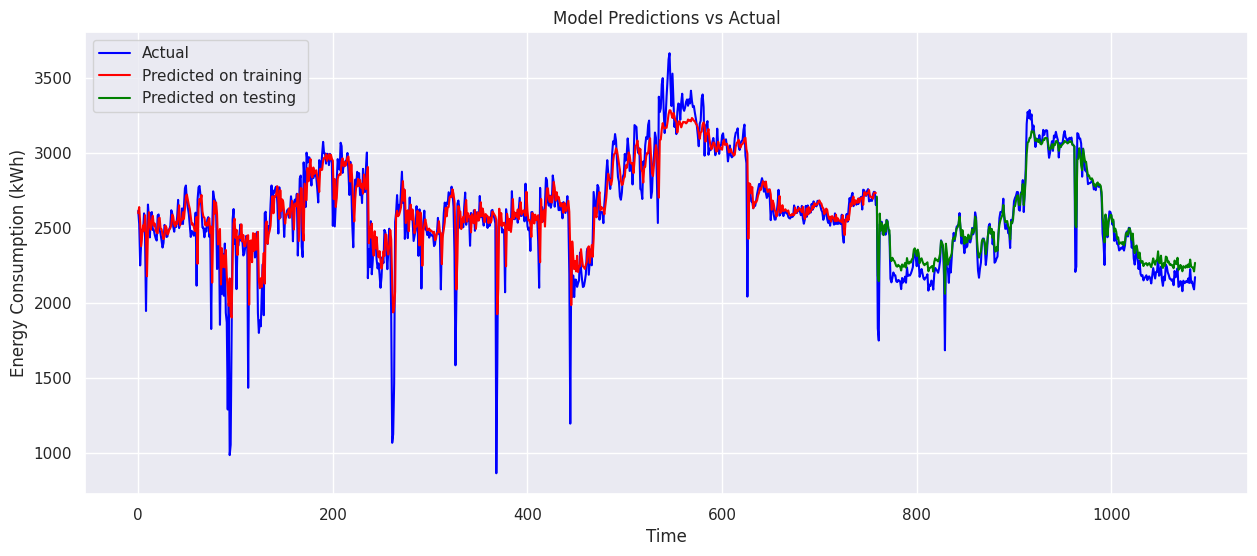

In [22]:
# Plot predictions
plot_original, plot_train, plot_test = plot_data_preparation(
    df["Daily Consumption"], predict_on_train, predict_on_test, lookback
)
plot_the_data(plot_original, plot_train, plot_test, "Model Predictions vs Actual")

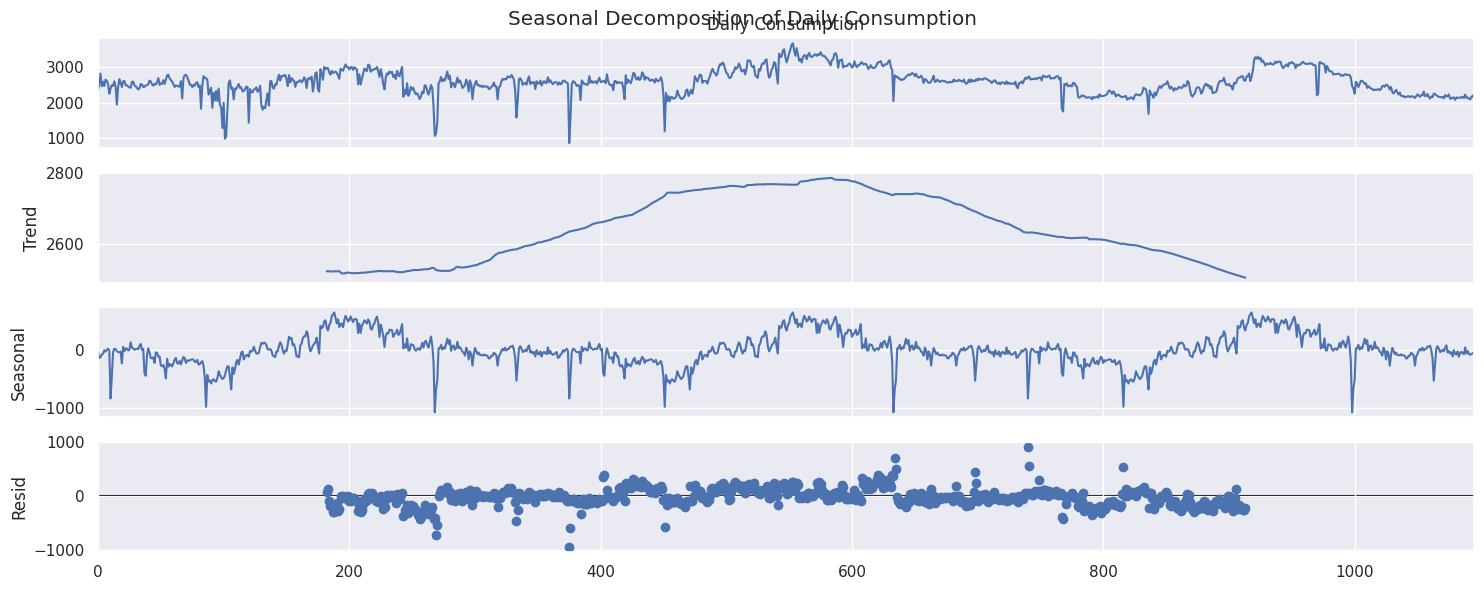

In [23]:
# Seasonal decomposition
result = seasonal_decompose(df["Daily Consumption"], model="additive", period=365)
result.plot()
plt.suptitle("Seasonal Decomposition of Daily Consumption")
plt.show()

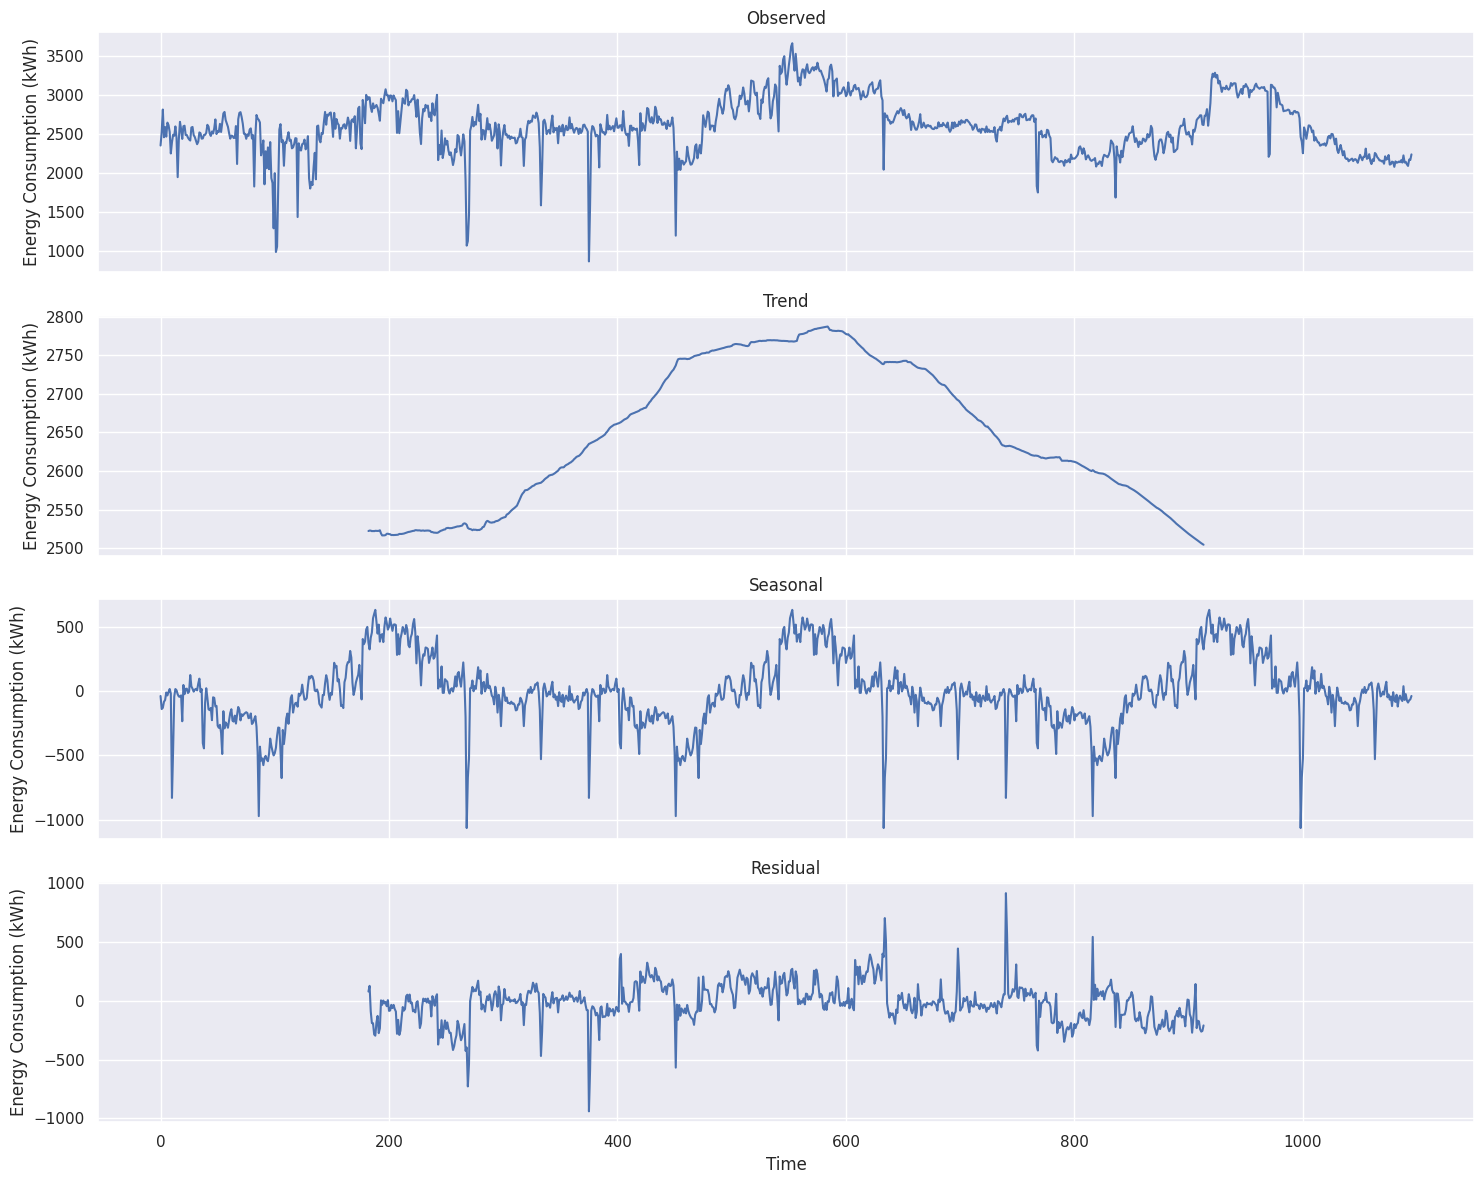

In [24]:
# Enhanced visualization of seasonal decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=axes[0], title="Observed")
result.trend.plot(ax=axes[1], title="Trend")
result.seasonal.plot(ax=axes[2], title="Seasonal")
result.resid.plot(ax=axes[3], title="Residual")
for ax in axes:
    ax.set_ylabel("Energy Consumption (kWh)")
axes[3].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [25]:
# Save the residuals to an Excel file
os.makedirs(building_name, exist_ok=True)
pd.DataFrame(result.resid).to_excel(
    f"{building_name}/avgbuilding.xlsx", sheet_name="Decomposition_Residuals"
)

In [26]:
# Summary statistics
residual_stats = pd.DataFrame(
    {
        "Mean": [result.resid.mean()],
        "Median": [result.resid.median()],
        "Standard Deviation": [result.resid.std()],
        "Max": [result.resid.max()],
        "Min": [result.resid.min()],
    }
)

In [27]:
# Save summary statistics
residual_stats.to_excel(f"{building_name}/avgresidual_statistics.xlsx", index=False)

In [28]:
# Display summary statistics
print("Summary Statistics of Residuals:")
print(residual_stats)

Summary Statistics of Residuals:
        Mean     Median  Standard Deviation         Max         Min
0 -14.271149 -13.575944          164.780814  910.791865 -939.334163


In [29]:
# Evaluation metrics
metrics = ts_model.evaluate(x_test, y_test, verbose=1)
metrics_df = pd.DataFrame([metrics], columns=["Loss", "MSE", "MAE", "MAPE"])

11/11 [==============================] - 0s 2ms/step - loss: 0.1363 - mse: 0.1363 - mae: 0.2457 - mape: 67.7061


In [30]:
# Save evaluation metrics
metrics_df.to_excel(f"{building_name}/avgevaluation_metrics.xlsx", index=False)

In [31]:
# Display evaluation metrics
print("Evaluation Metrics:")
print(metrics_df)

Evaluation Metrics:
       Loss       MSE       MAE       MAPE
0  0.136328  0.136328  0.245721  67.706131


In [32]:
# Federated Learning Model Preparation
def create_train_test_dataset(df, lookback):
    df["Daily Consumption"] = df.iloc[:, 1:-1].sum(axis=1)
    sc_X = StandardScaler()
    daily_consumption = df["Daily Consumption"]
    num_train = int(train_size * len(daily_consumption))
    daily_consumption_scaled = sc_X.fit_transform(
        daily_consumption.values.reshape(-1, 1)
    )
    training_set = daily_consumption_scaled[:num_train]
    x_train, y_train = create_rnn_dataset(training_set, lookback)
    test_data = daily_consumption_scaled[num_train - lookback :]
    x_test, y_test = create_rnn_dataset(test_data, lookback)
    return x_train, y_train, x_test, y_test, sc_X

In [33]:
# b1e_xtrain, b1e_ytrain, b1e_xtest, b1e_ytest, sc_b1e = create_train_test_dataset(
#     dictionary["building_1_electricity"], lookback
# )
# b2e_xtrain, b2e_ytrain, b2e_xtest, b2e_ytest, sc_b2e = create_train_test_dataset(
#     dictionary["building_2_electricity"], lookback
# )
# b3e_xtrain, b3e_ytrain, b3e_xtest, b3e_ytest, sc_b3e = create_train_test_dataset(
#     dictionary["building_3_electricity"], lookback
# )

train_test_dataset = []
# a convenient experiments due to index, in fact, 30 clients
for i in range(NUM_DATA_SHEETS):
    _x_train, _y_train, _x_test, _y_test, _sc_cl = create_train_test_dataset(dictionary[f'client_{str(i)}'], lookback)
    train_test_dataset.append((_x_train, _y_train, _x_test, _y_test, _sc_cl))

In [34]:
# b1e_model = create_model(input_shape=(1, lookback), output_shape=1)
# b2e_model = create_model(input_shape=(1, lookback), output_shape=1)
# b3e_model = create_model(input_shape=(1, lookback), output_shape=1)

model_arr = []
for i in range(NUM_DATA_SHEETS):
    _model = create_model(input_shape=(1, lookback), output_shape=1)
    model_arr.append(_model)

In [35]:
def train_model(model, x_train, y_train, log_dir):
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    early_stopping = EarlyStopping(
        monitor="loss", min_delta=0.001, patience=5, verbose=1, mode="auto"
    )
    model.fit(
        x_train,
        y_train,
        epochs=60,
        batch_size=1,
        verbose=1,
        callbacks=[tensorboard_callback, early_stopping],
    )

In [36]:
# train_model(b3e_model, b3e_xtrain, b3e_ytrain, "logs/fit/B3/")
# train_model(b1e_model, b1e_xtrain, b1e_ytrain, "logs/fit/B1/")
# train_model(b2e_model, b2e_xtrain, b2e_ytrain, "logs/fit/B2/")

for i in range(2, NUM_CLIENTS):
    _x_train, _y_train, _, _, _ = train_test_dataset[i]
    train_model(model_arr[i], _x_train, _y_train, f'logs/fit/avg{str(i)}')

Epoch 1/60
759/759 [==============================] - 2s 1ms/step - loss: 0.6877 - mse: 0.6877 - mae: 0.3570 - mape: 882.0709
Epoch 2/60
759/759 [==============================] - 1s 1ms/step - loss: 0.3524 - mse: 0.3524 - mae: 0.1539 - mape: 175.5282
Epoch 3/60
759/759 [==============================] - 1s 1ms/step - loss: 0.2873 - mse: 0.2873 - mae: 0.1361 - mape: 168.4907
Epoch 4/60
759/759 [==============================] - 1s 1ms/step - loss: 0.2444 - mse: 0.2444 - mae: 0.1241 - mape: 164.0486
Epoch 5/60
759/759 [==============================] - 1s 1ms/step - loss: 0.2056 - mse: 0.2056 - mae: 0.1209 - mape: 113.4752
Epoch 6/60
759/759 [==============================] - 1s 2ms/step - loss: 0.2066 - mse: 0.2066 - mae: 0.1194 - mape: 173.7249
Epoch 7/60
759/759 [==============================] - 1s 1ms/step - loss: 0.2244 - mse: 0.2244 - mae: 0.1245 - mape: 254.7950
Epoch 8/60
759/759 [==============================] - 1s 1ms/step - loss: 0.1977 - mse: 0.1977 - mae: 0.1135 - mape: 1

In [37]:
# Evaluate the models
def evaluate_model(model, x_train, y_train, x_test, y_test):
    model.evaluate(x_train, y_train)
    model.evaluate(x_test, y_test)

In [38]:
# evaluate_model(b3e_model, b3e_xtrain, b3e_ytrain, b3e_xtest, b3e_ytest)
# evaluate_model(b1e_model, b1e_xtrain, b1e_ytrain, b1e_xtest, b1e_ytest)
# evaluate_model(b2e_model, b2e_xtrain, b2e_ytrain, b2e_xtest, b2e_ytest)

for i in range(NUM_CLIENTS):
    _x_train, _y_train, _x_test, _y_test, _ = train_test_dataset[i]
    evaluate_model(model_arr[i], _x_train, _y_train, _x_test, _y_test)

11/11 [==============================] - 0s 1ms/step - loss: 0.1091 - mse: 0.1091 - mae: 0.2579 - mape: 64.8634


In [39]:
# Federated model training
client_matrix = pd.read_csv('client_status_data/client_status_random_on_off.csv').values

def federated_averaging(models, x_train, y_train, rounds=10):
    for r in range(rounds):
        weights = [model.get_weights() for model in models]
        new_weights = [
            np.mean([w[i] for w in weights], axis=0) for i in range(len(weights[0]))
        ]
        for model in models:
            model.set_weights(new_weights)
            model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=1)

def save_weights_to_csv(model, filename):
    """Save the model weights to a CSV file."""
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        for layer in model.weights:
            writer.writerow(layer.numpy().flatten())

def load_weights_from_csv(filename, model):
    """Load weights from a CSV file and set them to the model."""
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        new_weights = []
        for layer, row in zip(model.weights, reader):
            reshaped_weights = np.array(row, dtype=np.float32).reshape(layer.shape)
            new_weights.append(reshaped_weights)
        model.set_weights(new_weights)

def sum_weights_from_two_csvs(file1, file2, model):
    """Sum weights from two CSV files and set them to the model."""
    weights1 = []
    weights2 = []

    # Read weights from the first file
    with open(file1, 'r') as f1:
        reader1 = csv.reader(f1)
        weights1 = [np.array(row, dtype=np.float32) for row in reader1]

    # Read weights from the second file
    with open(file2, 'r') as f2:
        reader2 = csv.reader(f2)
        weights2 = [np.array(row, dtype=np.float32) for row in reader2]

    # Compute the sum of weights
    summed_weights = [0.2*w1 + 0.8*w2 for w1, w2 in zip(weights1, weights2)]

    # Reshape summed weights and set them to the model
    reshaped_weights = [
        weight.reshape(layer.shape) for weight, layer in zip(summed_weights, model.weights)
    ]
    model.set_weights(reshaped_weights)

def federated_weighing(models, x_train, y_train, round=10, has_weights_mechanism=False):
    history_dict = {}    
    for r in range(round):
        print(f"Round {r}:")
        history_dict[str(r)] = {}
        weights = [] #[model.get_weights() for model in models]
        for i in range(len(models)):
            if r >= 2 and client_matrix[r, i] == 'N':
                if has_weights_mechanism:
                    prev_csv_1 = f'weights_tracking_models/weights_tracking_model_client_{str(i)}_round_{str(r - 2)}.csv'
                    prev_csv_2 = f'weights_tracking_models/weights_tracking_model_client_{str(i)}_round_{str(r - 1)}.csv'
                    sum_weights_from_two_csvs(prev_csv_1, prev_csv_2, models[i])
                    print(f"Updated weights using the sum of round {r - 1} and {r - 2}")
                else:
                    continue
            
            weights.append(models[i].get_weights())
        
        new_weights = [
            np.mean([w[i] for w in weights], axis=0) for i in range(len(weights[0]))
        ]
        for i in range(len(models)):
            models[i].set_weights(new_weights)
            history = models[i].fit(x_train, y_train, epochs=5, batch_size=1, verbose=1)
            history_dict[str(r)][str(i)] = history 
            # Save weights
            if has_weights_mechanism:
                csv_file = f'weights_tracking_models/weights_tracking_model_client_{str(i)}_round_{str(r)}.csv'
                save_weights_to_csv(models[i], csv_file)
                print(f"Saved weights to {csv_file}")
    
    return history_dict

In [40]:
history_client_dict_avg = {}
for i in range(len(model_arr)):
    _x_train, _y_train, _, _, _ = train_test_dataset[i]
    print(f"Processing client {i}...")
    hist_dict_avg = federated_weighing(model_arr, _x_train, _y_train, has_weights_mechanism=False)
    history_client_dict_avg[f'client_{str(i)}'] = hist_dict_avg

Processing client 0...
Round 0:
Epoch 1/5
759/759 [==============================] - 2s 1ms/step - loss: 0.4291 - mse: 0.4291 - mae: 0.4741 - mape: 73.2660
Epoch 2/5
759/759 [==============================] - 1s 1ms/step - loss: 0.1783 - mse: 0.1783 - mae: 0.2415 - mape: 51.8152
Epoch 3/5
759/759 [==============================] - 1s 1ms/step - loss: 0.1527 - mse: 0.1527 - mae: 0.2238 - mape: 48.0639
Epoch 4/5
759/759 [==============================] - 1s 1ms/step - loss: 0.1461 - mse: 0.1461 - mae: 0.2202 - mape: 49.5177
Epoch 5/5
759/759 [==============================] - 1s 1ms/step - loss: 0.1403 - mse: 0.1403 - mae: 0.2177 - mape: 48.4167
Epoch 1/5
759/759 [==============================] - 2s 1ms/step - loss: 0.4291 - mse: 0.4291 - mae: 0.4741 - mape: 73.2660
Epoch 2/5
759/759 [==============================] - 1s 1ms/step - loss: 0.1783 - mse: 0.1783 - mae: 0.2415 - mape: 51.8152
Epoch 3/5
759/759 [==============================] - 1s 1ms/step - loss: 0.1527 - mse: 0.1527 - mae:

Epoch 1/60
759/759 [==============================] - 2s 1ms/step - loss: 0.4569 - mse: 0.4569 - mae: 0.4191 - mape: 417.1132
Epoch 2/60
759/759 [==============================] - 1s 1ms/step - loss: 0.3585 - mse: 0.3585 - mae: 0.3670 - mape: 369.0956
Epoch 3/60
759/759 [==============================] - 1s 2ms/step - loss: 0.3126 - mse: 0.3126 - mae: 0.3410 - mape: 328.2404
Epoch 4/60
759/759 [==============================] - 2s 2ms/step - loss: 0.2814 - mse: 0.2814 - mae: 0.3206 - mape: 277.9277
Epoch 5/60
759/759 [==============================] - 1s 2ms/step - loss: 0.2635 - mse: 0.2635 - mae: 0.3113 - mape: 290.6004
Epoch 6/60
759/759 [==============================] - 1s 2ms/step - loss: 0.2481 - mse: 0.2481 - mae: 0.2964 - mape: 263.8232
Epoch 7/60
759/759 [==============================] - 1s 2ms/step - loss: 0.2363 - mse: 0.2363 - mae: 0.2922 - mape: 251.6396
Epoch 8/60
759/759 [==============================] - 1s 2ms/step - loss: 0.2222 - mse: 0.2222 - mae: 0.2846 - mape: 2

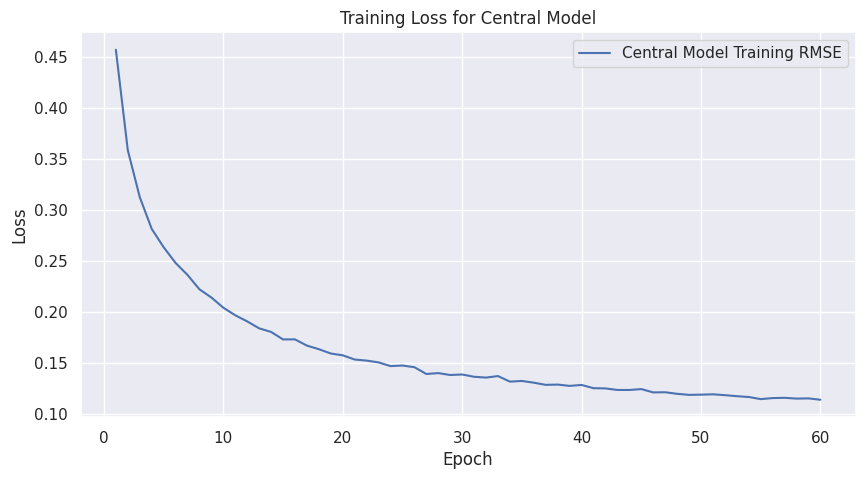

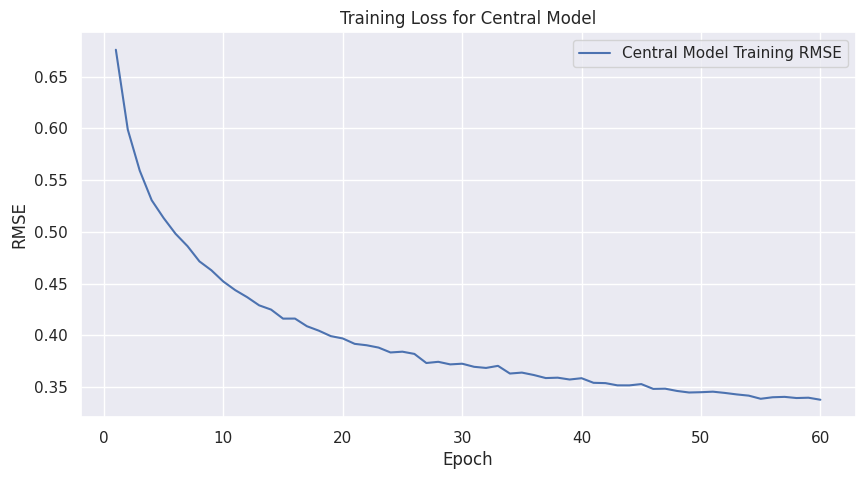

In [54]:
# Get loss of central model after training all round with all clients
central_x_train, central_y_tran, _, _, _ = train_test_dataset[0]
central_model = create_model(input_shape=(1, lookback), output_shape=1)
weights = [model.get_weights() for model in model_arr]
new_weights = [
            np.mean([w[i] for w in weights], axis=0) for i in range(len(weights[0]))
        ]
central_model.set_weights(new_weights)
central_history = central_model.fit(x_train, y_train, epochs=60, batch_size=1, verbose=1)

losses = central_history.history['loss']
rmses = [x**(1/2) for x in central_history.history['mse']]

# Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, label=f'Central Model Training RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Training Loss for Central Model')
plt.show()

# RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rmses) + 1), rmses, label=f'Central Model Training RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title(f'Training Loss for Central Model')
plt.show()

In [51]:
def to_json(filepath, history_dict):
    with open(filepath, "w") as f:
        json.dump(history_dict, f)

def to_pickle(filepath, history_dict):
    with open(filepath, 'wb') as file_pi:
        pickle.dump(history_dict, file_pi)

# to_pickle("pickles/FL-dict-avg.pkl", history_client_dict_avg)
# to_json("FL-dict-avg.json", history_client_dict_avg)

In [55]:
losses_rmses_dict = {
    "losses": losses,
    "rmses": rmses
}

to_json("model_history/avg/losses_rmses.json", losses_rmses_dict)

In [42]:
# Predictions and plotting
def inverse_transform_predictions(predictions, scaler):
    return scaler.inverse_transform(predictions)

In [43]:
# b1_train_predictions = inverse_transform_predictions(
#     b1e_model.predict(b1e_xtrain), sc_b1e
# )
# b2_train_predictions = inverse_transform_predictions(
#     b2e_model.predict(b2e_xtrain), sc_b2e
# )
# b3_train_predictions = inverse_transform_predictions(
#     b3e_model.predict(b3e_xtrain), sc_b3e
# )

train_predictions_arr = []
for i in range(NUM_CLIENTS):
    _x_train, _y_train, _x_test, _y_test, _sc_cl = train_test_dataset[i]
    _train_predictions = inverse_transform_predictions(model_arr[i].predict(_x_train), _sc_cl)
    train_predictions_arr.append(_train_predictions)

24/24 [==============================] - 0s 2ms/step


In [44]:
# b1_test_predictions = inverse_transform_predictions(
#     b1e_model.predict(b1e_xtest), sc_b1e
# )
# b2_test_predictions = inverse_transform_predictions(
#     b2e_model.predict(b2e_xtest), sc_b2e
# )
# b3_test_predictions = inverse_transform_predictions(
#     b3e_model.predict(b3e_xtest), sc_b3e
# )

test_predictions_arr = []
for i in range(NUM_CLIENTS):
    _x_train, _y_train, _x_test, _y_test, _sc_cl = train_test_dataset[i]
    _test_predictions = inverse_transform_predictions(model_arr[i].predict(_x_test), _sc_cl)
    test_predictions_arr.append(_test_predictions)

11/11 [==============================] - 0s 2ms/step


In [45]:
def prepare_and_plot(data, train_predictions, test_predictions, lookback, title):
    orig_plot, train_plot, test_plot = plot_data_preparation(
        data, train_predictions, test_predictions, lookback
    )
    plot_the_data(orig_plot, train_plot, test_plot, title)

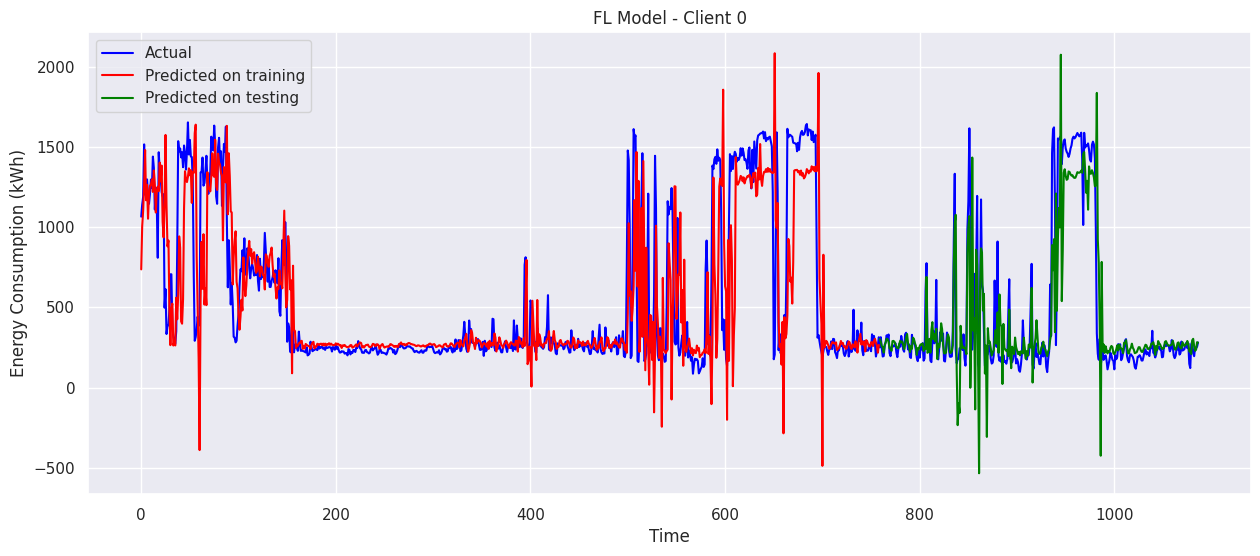

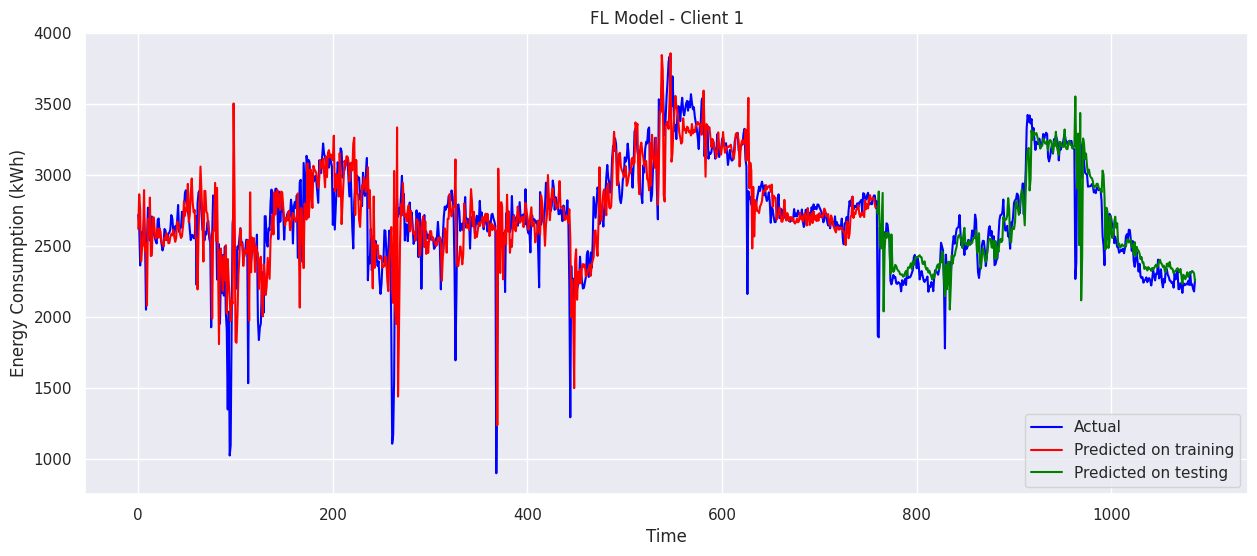

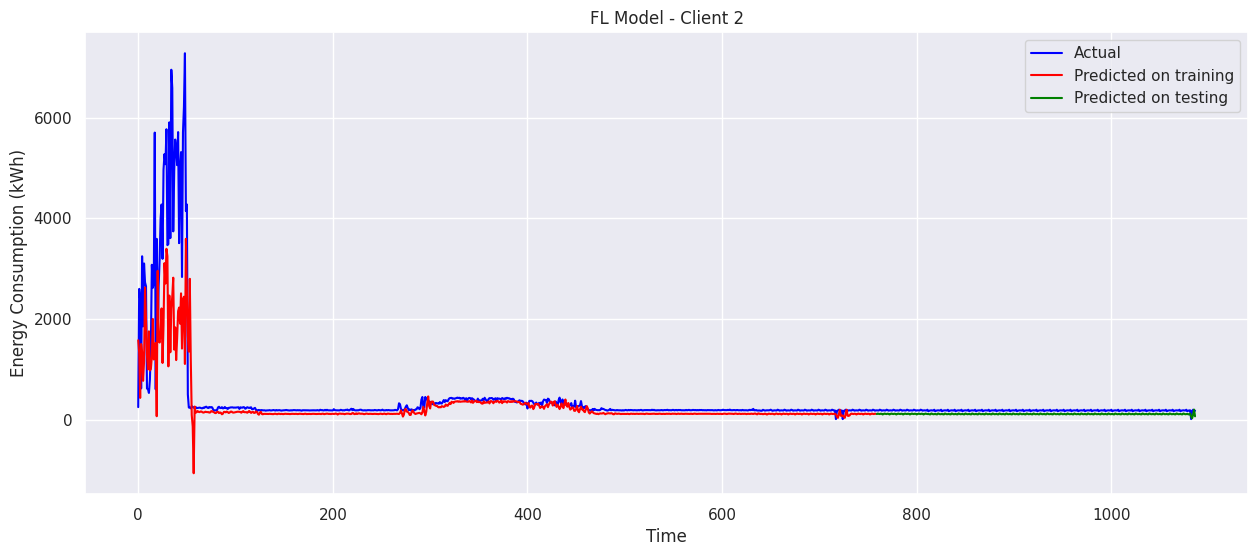

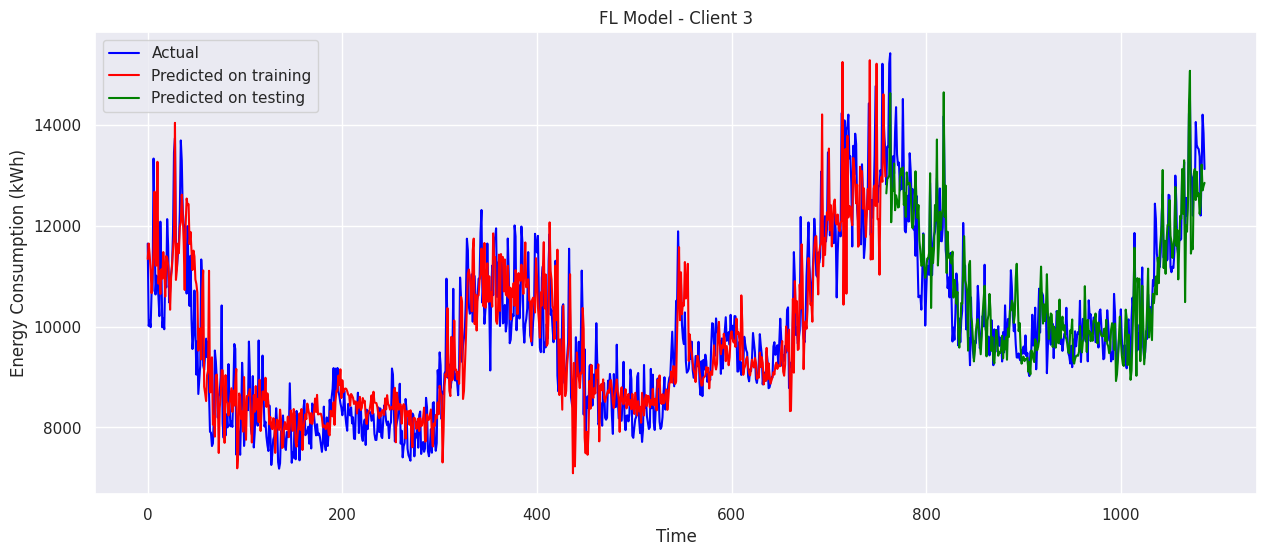

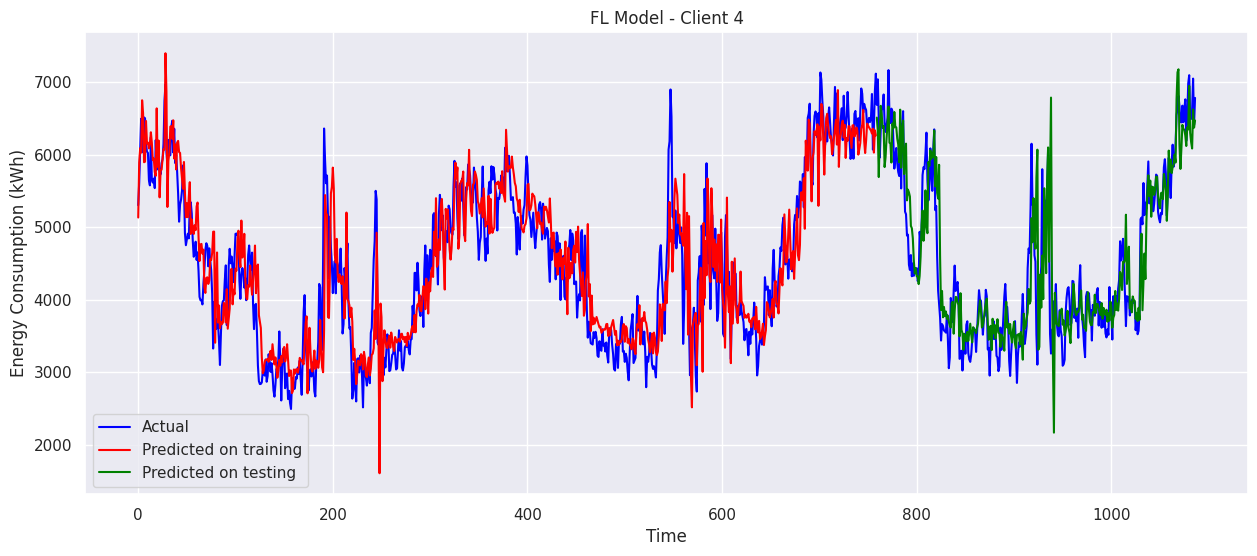

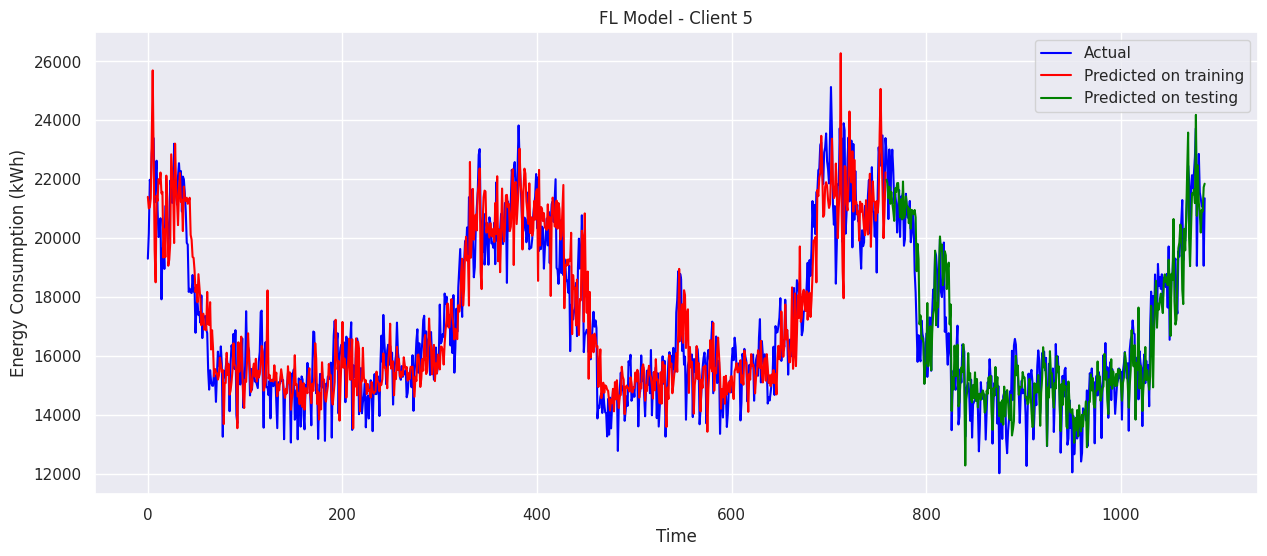

In [46]:
# prepare_and_plot(
#     dictionary["building_1_electricity"]["Daily consumption"],
#     b1_train_predictions,
#     b1_test_predictions,
#     lookback,
#     "Federated Model - Building 1",
# )
# prepare_and_plot(
#     dictionary["building_2_electricity"]["Daily consumption"],
#     b2_train_predictions,
#     b2_test_predictions,
#     lookback,
#     "Federated Model - Building 2",
# )
# prepare_and_plot(
#     dictionary["building_3_electricity"]["Daily consumption"],
#     b3_train_predictions,
#     b3_test_predictions,
#     lookback,
#     "Federated Model - Building 3",
# )

for i in range(NUM_CLIENTS):
    prepare_and_plot(
        dictionary[f'client_{i}']['Daily Consumption'],
        train_predictions_arr[i],
        test_predictions_arr[i],
        lookback,
        f"FL Model - Client {i}"
    )

In [47]:
# Save the predictions
output_dir = "avgfederated"
os.makedirs(output_dir, exist_ok=True)

In [48]:
# predictions_files = {
#     "b1_test_predictions": b1_test_predictions,
#     "b2_test_predictions": b2_test_predictions,
#     "b3_test_predictions": b3_test_predictions,
#     "b1_train_predictions": b1_train_predictions,
#     "b2_train_predictions": b2_train_predictions,
#     "b3_train_predictions": b3_train_predictions,
#     "b1_original": dictionary["building_1_electricity"]["Daily consumption"],
#     "b2_original": dictionary["building_2_electricity"]["Daily consumption"],
#     "b3_original": dictionary["building_3_electricity"]["Daily consumption"],
# }

predictions_files = {}
for i in range(NUM_CLIENTS):
    predictions_files[f'client{i}_test_predictions'] = test_predictions_arr[i]
    predictions_files[f'client{i}_train_predictions'] = train_predictions_arr[i]
    predictions_files[f'client{i}_original'] = dictionary[f'client_{i}']['Daily Consumption']

In [49]:
for filename, data in predictions_files.items():
    pd.DataFrame(data).to_excel(f"{output_dir}/avg{filename}.xlsx")

In [52]:
history_client_dict_avg['client_3']['9']['7'].history['loss']

hist_output_dir = "model_history/avg"

def save_model_history(history_dict):
    for client in history_dict.keys():
        for round in history_dict[client].keys():
            for model in history_dict[client][round].keys():
                dir = f'{hist_output_dir}/client_{client}/round_{round}/model_{model}'
                if not os.path.exists(dir):
                    os.makedirs(dir)
                jsonfile = f'{dir}/history.json'
                to_json(jsonfile, history_dict[client][round][model].history)

save_model_history(history_client_dict_avg)